## This notebook prepares for decoding (both 1D and 2D)
#### 20 ms window 10 ms window overlap
### Use this notebook to run session/day of each dataset from new animal

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import os
import cupy as cp

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [4]:
from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection
from spyglass.common.common_position import IntervalLinearizedPosition

import spyglass.spikesorting.v0 as ss
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection

from replay_trajectory_classification.environments import Environment
from spyglass.common.common_position import TrackGraph
from spyglass.decoding.v0.clusterless import ClusterlessClassifierParameters
from replay_trajectory_classification import ClusterlessClassifier



import pprint
# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import EpochPos,TrialChoice,Decode,DecodeResultsLinear,DecodeIngredients,DecodeIngredientsLikelihood
from spyglass.shijiegu.decodeHelpers import (thresholder_sort, runSessionNames,
    sleepSessionNames, populateUnitMarks, intersectValidIntervals)
from spyglass.shijiegu.decodeHelpers import decodePrepMasterSession

[2025-05-05 08:26:33,035][INFO]: DataJoint 0.14.4 connected to shijiegu-alt@lmf-db.cin.ucsf.edu:3306
05-May-25 08:26:33 DataJoint 0.14.4 connected to shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [5]:
from spyglass.shijiegu.likelihoodDecode_helper import decodePrepLikelihoodMasterSession

In [25]:
nwb_copy_file_name = 'eliot20221021_.nwb'

In [26]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']


In [27]:
sleep_interval, sleep_position_interval = sleepSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']


In [ ]:
for session_name in session_interval:
    print("working on",session_name)
    decodePrepLikelihoodMasterSession(nwb_copy_file_name,
                                      session_name,window_size = 0.02,overlap_size = 0.01)

working on 02_Rev2Session1


In [28]:
DecodeIngredientsLikelihood & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,"window_size in seconds, time window in which you lump neural data for decoding","overlap_size in seconds, time window in which you overlap for decoding",marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"
eliot20221021_.nwb,02_Seq2Session1,0.02,0.01,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,02_Seq2Session1,0.04,0.02,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,04_Seq2Session2,0.02,0.01,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,04_Seq2Session2,0.04,0.02,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,06_Seq2Session3,0.02,0.01,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,06_Seq2Session3,0.04,0.02,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,08_Seq2Session4,0.02,0.01,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,08_Seq2Session4,0.04,0.02,=BLOB=,=BLOB=,=BLOB=


In [19]:
DecodeIngredientsLikelihood()

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,"window_size in seconds, time window in which you lump neural data for decoding","overlap_size in seconds, time window in which you overlap for decoding",marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"
eliot20221021_.nwb,02_Seq2Session1,0.02,0.01,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,02_Seq2Session1,0.04,0.02,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,04_Seq2Session2,0.02,0.01,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,04_Seq2Session2,0.04,0.02,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,06_Seq2Session3,0.02,0.01,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,06_Seq2Session3,0.04,0.02,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,08_Seq2Session4,0.02,0.01,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,08_Seq2Session4,0.04,0.02,=BLOB=,=BLOB=,=BLOB=
lewis20240109_.nwb,02_Rev2Session1,0.04,0.02,=BLOB=,=BLOB=,=BLOB=
lewis20240109_.nwb,04_Rev2Session2,0.04,0.02,=BLOB=,=BLOB=,=BLOB=


In [8]:
DecodeResultsLinear & {'nwb_file_name':"eliot20221021_.nwb"}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,classifier_param_name a name for this set of parameters,encoding_set a name for this set of encoding,posterior posterior within that interval (1D)
eliot20221021_.nwb,02_Seq2Session1,causal_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,=BLOB=
eliot20221021_.nwb,02_Seq2Session1,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=
eliot20221021_.nwb,02_Seq2Session1,default_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,=BLOB=
eliot20221021_.nwb,02_Seq2Session1,default_decoding_gpu_4armMaze,all_maze,=BLOB=
eliot20221021_.nwb,02_Seq2Session1,default_decoding_gpu_4armMaze,mobility_2Dheadspeed_above_6,=BLOB=
eliot20221021_.nwb,02_Seq2Session1,default_decoding_gpu_4armMaze_W20msO10ms,2Dheadspeed_above_4,=BLOB=
eliot20221021_.nwb,02_Seq2Session1,default_decoding_gpu_4armMaze_W40msO20ms,2Dheadspeed_above_4,=BLOB=
eliot20221021_.nwb,04_Seq2Session2,causal_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,=BLOB=
eliot20221021_.nwb,04_Seq2Session2,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=
eliot20221021_.nwb,04_Seq2Session2,default_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,=BLOB=


# End here

In [318]:
from spyglass.shijiegu.likelihoodDecode_helper import decimate_sum_marks

In [391]:
entry = DecodeIngredientsLikelihood & {'nwb_file_name':nwb_copy_file_name,
             'interval_list_name':session_interval[0],"window_size":0.04,"overlap_size":0.02}
marks_ll = xr.open_dataset(entry.fetch1('marks'))

In [392]:
marks_time_ll = marks_ll.time

In [393]:
marks_time_ll[10] - marks_time_ll[9]

<xarray.DataArray 'time' ()>
array(0.01999998)

In [329]:
entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
             'interval_list_name':session_interval[0]}
marks = xr.open_dataset(entry.fetch1('marks'))

mark_subset = np.array(marks.sel({"electrodes":31}).to_dataarray()).squeeze()
print(mark_subset.shape)
np.sum(~np.isnan(mark_subset[:,2]))

(1111304, 4)


11706

In [357]:
marks

<xarray.Dataset>
Dimensions:                        (time: 1111304, marks: 4, electrodes: 16)
Coordinates:
  * time                           (time) float64 1.666e+09 ... 1.666e+09
  * electrodes                     (electrodes) int32 0 2 4 5 13 ... 28 29 30 31
  * marks                          (marks) object 'amplitude_0000' ... 'ampli...
Data variables:
    __xarray_dataarray_variable__  (time, marks, electrodes) float32 ...

In [354]:
entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
             'interval_list_name':session_interval[0]}
marks = xr.open_dataset(entry.fetch1('marks'))

In [355]:
marks_time = marks.time

In [356]:
marks_time[10] - marks_time[9]

<xarray.DataArray 'time' ()>
array(0.00200009)

In [372]:
from spyglass.shijiegu.likelihoodDecode_helper import decimate_ave_pos, decimate_sum_marks

In [380]:
marks_path = ( DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
                                    'interval_list_name':session_name} ).fetch1("marks")
marks = xr.open_dataset(marks_path)

pos1d_path = ( DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
                        'interval_list_name':session_name} ).fetch1("position_1d")
pos1d = pd.read_csv(pos1d_path)

pos2d_path = ( DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
                        'interval_list_name':session_name} ).fetch1("position_2d")
pos2d = pd.read_csv(pos2d_path)
    
# low pass (convolution + decimating)
N = int(overlap_size * 1000 / 2) # 5x2 = 10ms
pos1d_decimate = decimate_ave_pos(pos1d, N)
pos2d_decimate = decimate_ave_pos(pos2d, N)
marks_decimate = decimate_sum_marks(marks, N)

# overlap (convolution)
#M = int( window_size / overlap_size ) # 2 bins x 10ms/bin = 20 ms
#pos1d_overlap = decimate_ave_pos(pos1d_decimate, M, decimate_flag = False)
#pos2d_overlap = decimate_ave_pos(pos2d_decimate, M, decimate_flag = False)
#marks_overlap = decimate_sum_marks(marks_decimate, M, decimate_flag = False)

In [378]:
N

5

In [381]:
pos1d_decimate.time[10] - pos1d_decimate.time[9]

0.010000228881835938

In [382]:
marks_decimate.time[10] - marks_decimate.time[9]

<xarray.DataArray 'time' ()>
array(0.01000023)

In [338]:
N

5.0

In [340]:
mark_subset = np.array(marks_out.sel({"electrodes":31}).to_dataarray()).squeeze()
print(mark_subset.shape)
np.sum(~np.isnan(mark_subset[:,2]))

(222260, 4)


10725

In [278]:
np.argwhere(~np.isnan(mark_subset[:,2]))[:1000]

array([[   567],
       [   727],
       [  1015],
       [  1029],
       [  1513],
       [  1554],
       [  1562],
       [  1730],
       [  1747],
       [  1799],
       [  1997],
       [  2063],
       [  3174],
       [  3200],
       [  3345],
       [  3608],
       [  3649],
       [  3655],
       [  3711],
       [  3720],
       [  3802],
       [  3805],
       [  3870],
       [  3989],
       [  4011],
       [  4029],
       [  4055],
       [  4062],
       [  4123],
       [  4132],
       [  4294],
       [  4327],
       [  4384],
       [  4393],
       [  4401],
       [  4488],
       [  4496],
       [  4551],
       [  4560],
       [  4639],
       [  4654],
       [  4658],
       [  4826],
       [  4842],
       [  4910],
       [  5023],
       [  5042],
       [  5047],
       [  5055],
       [  5060],
       [  5224],
       [  5379],
       [  5542],
       [  5631],
       [  5705],
       [  5771],
       [  5776],
       [  5874],
       [  5883

In [308]:
entry = DecodeIngredientsLikelihood & {'nwb_file_name':nwb_copy_file_name,
             'interval_list_name':session_interval[0]}
    
# Get data
marks = xr.open_dataset(entry.fetch1('marks'))
position_1d = pd.read_csv(entry.fetch1('position_1d'))
position_2d = pd.read_csv(entry.fetch1('position_2d')) #still need 2D position

In [309]:
mark_subset = np.array(marks.sel({"electrodes":31}).to_dataarray()).squeeze()
print(mark_subset.shape)
np.sum(~np.isnan(mark_subset[:,2]))

(222259, 4)


0

In [286]:
np.sum(~np.isnan(mark_subset[:10000,2]))

94

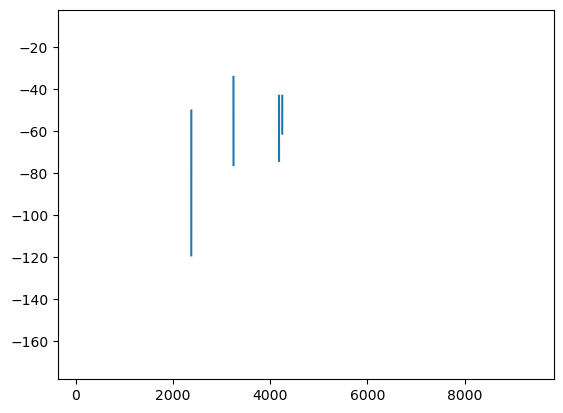

In [289]:
plt.plot(mark_subset[10000:20000,2])

In [266]:
mark_test = decimate(mark_subset[:,2], 5, decimate_flag = True)

In [284]:
np.argwhere(~np.isnan(mark_test))

array([], shape=(0, 1), dtype=int64)

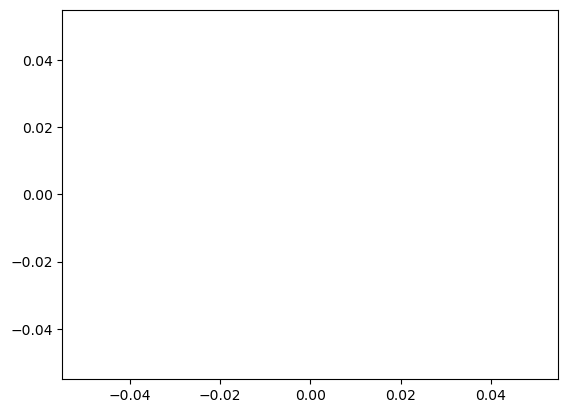

In [268]:
plt.plot(mark_test)

0


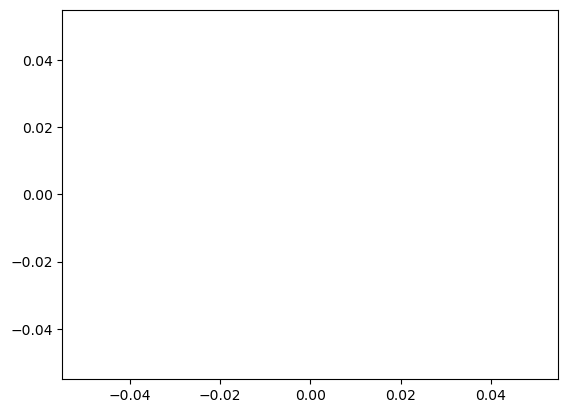

In [259]:
mark_subset = np.array(marks_decimate.sel({"electrodes":31}).to_dataarray()).squeeze()
print(np.sum(~np.isnan(mark_subset[:,2])))
plt.plot(mark_subset[:,2],mark_subset[:,3])

In [ ]:
mark_parameters_keys = populateUnitMarks(sorting_keys)

[15:36:46][INFO] Spyglass: Found 1 accepted units
19-Sep-24 15:36:46 Found 1 accepted units
[15:36:50][INFO] Spyglass: Writing new NWB file lewis20240106_F81ZWHGISE.nwb
19-Sep-24 15:36:50 Writing new NWB file lewis20240106_F81ZWHGISE.nwb
[15:36:52][INFO] Spyglass: Found 1 accepted units
19-Sep-24 15:36:52 Found 1 accepted units
[15:36:53][INFO] Spyglass: Writing new NWB file lewis20240106_K7SD8JFPNM.nwb
19-Sep-24 15:36:53 Writing new NWB file lewis20240106_K7SD8JFPNM.nwb
[15:36:54][INFO] Spyglass: Found 1 accepted units
19-Sep-24 15:36:54 Found 1 accepted units
[15:36:55][INFO] Spyglass: Writing new NWB file lewis20240106_0DBKZZIR2A.nwb
19-Sep-24 15:36:55 Writing new NWB file lewis20240106_0DBKZZIR2A.nwb
[15:36:57][INFO] Spyglass: Found 1 accepted units
19-Sep-24 15:36:57 Found 1 accepted units
[15:36:58][INFO] Spyglass: Writing new NWB file lewis20240106_UT75NCSCER.nwb
19-Sep-24 15:36:58 Writing new NWB file lewis20240106_UT75NCSCER.nwb
[15:37:00][INFO] Spyglass: Found 1 accepted unit

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:38:50][INFO] Spyglass: Writing new NWB file lewis20240106_VMTGJO4LU9.nwb
19-Sep-24 15:38:50 Writing new NWB file lewis20240106_VMTGJO4LU9.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:38:55][INFO] Spyglass: Writing new NWB file lewis20240106_RAAQA9SBL1.nwb
19-Sep-24 15:38:55 Writing new NWB file lewis20240106_RAAQA9SBL1.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:00][INFO] Spyglass: Writing new NWB file lewis20240106_A16IPR23VE.nwb
19-Sep-24 15:39:00 Writing new NWB file lewis20240106_A16IPR23VE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:04][INFO] Spyglass: Writing new NWB file lewis20240106_HSFQP3QG98.nwb
19-Sep-24 15:39:04 Writing new NWB file lewis20240106_HSFQP3QG98.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:10][INFO] Spyglass: Writing new NWB file lewis20240106_QP8IZ2T8II.nwb
19-Sep-24 15:39:10 Writing new NWB file lewis20240106_QP8IZ2T8II.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:15][INFO] Spyglass: Writing new NWB file lewis20240106_EKJMEMGF7K.nwb
19-Sep-24 15:39:15 Writing new NWB file lewis20240106_EKJMEMGF7K.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:20][INFO] Spyglass: Writing new NWB file lewis20240106_9NW57A4AP7.nwb
19-Sep-24 15:39:20 Writing new NWB file lewis20240106_9NW57A4AP7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:24][INFO] Spyglass: Writing new NWB file lewis20240106_VHRWOKFZGP.nwb
19-Sep-24 15:39:24 Writing new NWB file lewis20240106_VHRWOKFZGP.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:30][INFO] Spyglass: Writing new NWB file lewis20240106_4DM10Y7VRZ.nwb
19-Sep-24 15:39:30 Writing new NWB file lewis20240106_4DM10Y7VRZ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:34][INFO] Spyglass: Writing new NWB file lewis20240106_KVR2CUMA9B.nwb
19-Sep-24 15:39:34 Writing new NWB file lewis20240106_KVR2CUMA9B.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:39][INFO] Spyglass: Writing new NWB file lewis20240106_1DQQPOGHTY.nwb
19-Sep-24 15:39:39 Writing new NWB file lewis20240106_1DQQPOGHTY.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:43][INFO] Spyglass: Writing new NWB file lewis20240106_D9JPJ3PAIM.nwb
19-Sep-24 15:39:43 Writing new NWB file lewis20240106_D9JPJ3PAIM.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:48][INFO] Spyglass: Writing new NWB file lewis20240106_PBD754ENC6.nwb
19-Sep-24 15:39:48 Writing new NWB file lewis20240106_PBD754ENC6.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:53][INFO] Spyglass: Writing new NWB file lewis20240106_4QR543WOUD.nwb
19-Sep-24 15:39:53 Writing new NWB file lewis20240106_4QR543WOUD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:39:57][INFO] Spyglass: Writing new NWB file lewis20240106_TUW9K9RFVS.nwb
19-Sep-24 15:39:57 Writing new NWB file lewis20240106_TUW9K9RFVS.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:02][INFO] Spyglass: Writing new NWB file lewis20240106_IZ3EW0D0RP.nwb
19-Sep-24 15:40:02 Writing new NWB file lewis20240106_IZ3EW0D0RP.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:06][INFO] Spyglass: Writing new NWB file lewis20240106_G6U8R65N30.nwb
19-Sep-24 15:40:06 Writing new NWB file lewis20240106_G6U8R65N30.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:11][INFO] Spyglass: Writing new NWB file lewis20240106_ZB7M20ABXG.nwb
19-Sep-24 15:40:11 Writing new NWB file lewis20240106_ZB7M20ABXG.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:15][INFO] Spyglass: Writing new NWB file lewis20240106_AG7EAEAZCB.nwb
19-Sep-24 15:40:15 Writing new NWB file lewis20240106_AG7EAEAZCB.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:20][INFO] Spyglass: Writing new NWB file lewis20240106_BC653V6EXG.nwb
19-Sep-24 15:40:20 Writing new NWB file lewis20240106_BC653V6EXG.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:24][INFO] Spyglass: Writing new NWB file lewis20240106_9KS1FPCX68.nwb
19-Sep-24 15:40:24 Writing new NWB file lewis20240106_9KS1FPCX68.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:29][INFO] Spyglass: Writing new NWB file lewis20240106_T5CJ6U1R12.nwb
19-Sep-24 15:40:29 Writing new NWB file lewis20240106_T5CJ6U1R12.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:33][INFO] Spyglass: Writing new NWB file lewis20240106_SO7I4QHULD.nwb
19-Sep-24 15:40:33 Writing new NWB file lewis20240106_SO7I4QHULD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:38][INFO] Spyglass: Writing new NWB file lewis20240106_SVV9ULV7WF.nwb
19-Sep-24 15:40:38 Writing new NWB file lewis20240106_SVV9ULV7WF.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:42][INFO] Spyglass: Writing new NWB file lewis20240106_QG2PLO0FN6.nwb
19-Sep-24 15:40:42 Writing new NWB file lewis20240106_QG2PLO0FN6.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:47][INFO] Spyglass: Writing new NWB file lewis20240106_EIEOOA6YK0.nwb
19-Sep-24 15:40:47 Writing new NWB file lewis20240106_EIEOOA6YK0.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:51][INFO] Spyglass: Writing new NWB file lewis20240106_1C0X01X2CM.nwb
19-Sep-24 15:40:51 Writing new NWB file lewis20240106_1C0X01X2CM.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:40:56][INFO] Spyglass: Writing new NWB file lewis20240106_UJ3KSRRXPV.nwb
19-Sep-24 15:40:56 Writing new NWB file lewis20240106_UJ3KSRRXPV.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:01][INFO] Spyglass: Writing new NWB file lewis20240106_0535WOG0RA.nwb
19-Sep-24 15:41:01 Writing new NWB file lewis20240106_0535WOG0RA.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:05][INFO] Spyglass: Writing new NWB file lewis20240106_UGATWBXRZC.nwb
19-Sep-24 15:41:05 Writing new NWB file lewis20240106_UGATWBXRZC.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:10][INFO] Spyglass: Writing new NWB file lewis20240106_JG9ZVFUNYO.nwb
19-Sep-24 15:41:10 Writing new NWB file lewis20240106_JG9ZVFUNYO.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:14][INFO] Spyglass: Writing new NWB file lewis20240106_Z7U2S1YUZH.nwb
19-Sep-24 15:41:14 Writing new NWB file lewis20240106_Z7U2S1YUZH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:19][INFO] Spyglass: Writing new NWB file lewis20240106_RA9E9HHYOR.nwb
19-Sep-24 15:41:19 Writing new NWB file lewis20240106_RA9E9HHYOR.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:23][INFO] Spyglass: Writing new NWB file lewis20240106_STZGCYYANF.nwb
19-Sep-24 15:41:23 Writing new NWB file lewis20240106_STZGCYYANF.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:27][INFO] Spyglass: Writing new NWB file lewis20240106_KAV9ZUKDHS.nwb
19-Sep-24 15:41:27 Writing new NWB file lewis20240106_KAV9ZUKDHS.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:32][INFO] Spyglass: Writing new NWB file lewis20240106_8L5EHS5I3R.nwb
19-Sep-24 15:41:32 Writing new NWB file lewis20240106_8L5EHS5I3R.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:36][INFO] Spyglass: Writing new NWB file lewis20240106_00AE7TWEA3.nwb
19-Sep-24 15:41:36 Writing new NWB file lewis20240106_00AE7TWEA3.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:41][INFO] Spyglass: Writing new NWB file lewis20240106_Z13KLH5Q9J.nwb
19-Sep-24 15:41:41 Writing new NWB file lewis20240106_Z13KLH5Q9J.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:41:46][INFO] Spyglass: Writing new NWB file lewis20240106_3NTHN8NSY5.nwb
19-Sep-24 15:41:46 Writing new NWB file lewis20240106_3NTHN8NSY5.nwb


In [20]:
(SpikeSorting & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
lewis20240106_.nwb,0,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_0_franklab_tetrode_hippocampus_1d852f1d_spikesorting,1726783462
lewis20240106_.nwb,1,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_1_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_1_franklab_tetrode_hippocampus_9ffcc9e8_spikesorting,1726783520
lewis20240106_.nwb,7,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_7_franklab_tetrode_hippocampus_1da227df_spikesorting,1726783749
lewis20240106_.nwb,8,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_8_franklab_tetrode_hippocampus_77a0534b_spikesorting,1726783756
lewis20240106_.nwb,9,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_9_franklab_tetrode_hippocampus_5e3fcb8f_spikesorting,1726783763
lewis20240106_.nwb,10,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_10_franklab_tetrode_hippocampus_ac64901e_spikesorting,1726783471
lewis20240106_.nwb,12,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_12_franklab_tetrode_hippocampus_8bd01fcc_spikesorting,1726783479
lewis20240106_.nwb,13,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_13_franklab_tetrode_hippocampus_046e2656_spikesorting,1726783485
lewis20240106_.nwb,15,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_15_franklab_tetrode_hippocampus_7a460a1f_spikesorting,1726783494
lewis20240106_.nwb,17,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/lewis20240106_.nwb_02_Rev2Session1_17_franklab_tetrode_hippocampus_1ddbdee8_spikesorting,1726783500


In [21]:
len(sorting_keys)

43

In [60]:
sorting_keys[0]

{'nwb_file_name': 'eliot20221018_.nwb',
 'sort_interval_name': '05_Seq2Session3',
 'sort_group_id': 0,
 'preproc_params_name': 'franklab_tetrode_hippocampus',
 'team_name': 'Shijie Gu',
 'artifact_removed_interval_list_name': 'eliot20221018_.nwb_05_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only',
 'sorter': 'clusterless_thresholder',
 'sorter_params_name': 'default',
 'curation_id': 0,
 'parent_curation_id': -1,
 'description': '',
 'curation_labels': {},
 'merge_groups': [],
 'quality_metrics': {},
 'time_of_creation': 1719979418}

In [75]:
positionIntervalList = (
        IntervalList &
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]})

marks_selection = ((UnitMarks & mark_parameters_keys) * positionIntervalList)
marks_selection = (pd.DataFrame(marks_selection)
                   .loc[:, marks_selection.primary_key]
                   .to_dict('records'))
UnitMarksIndicatorSelection.insert(marks_selection, skip_duplicates=True)

NameError: name 'mark_parameters_keys' is not defined

In [ ]:
UnitMarksIndicatorSelection() & {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': position_interval[e]}

In [23]:
UnitMarksIndicator.populate(marks_selection)

[12:25:38][INFO] Spyglass: Writing new NWB file lewis20240106_7AH4IIOEM0.nwb
30-Sep-24 12:25:38 Writing new NWB file lewis20240106_7AH4IIOEM0.nwb
[12:25:50][INFO] Spyglass: Writing new NWB file lewis20240106_ORD29QT3IC.nwb
30-Sep-24 12:25:50 Writing new NWB file lewis20240106_ORD29QT3IC.nwb
[12:26:01][INFO] Spyglass: Writing new NWB file lewis20240106_S13BYYF5I0.nwb
30-Sep-24 12:26:01 Writing new NWB file lewis20240106_S13BYYF5I0.nwb
[12:26:14][INFO] Spyglass: Writing new NWB file lewis20240106_WSKT39KR0T.nwb
30-Sep-24 12:26:14 Writing new NWB file lewis20240106_WSKT39KR0T.nwb
[12:26:25][INFO] Spyglass: Writing new NWB file lewis20240106_KKD9H46CCX.nwb
30-Sep-24 12:26:25 Writing new NWB file lewis20240106_KKD9H46CCX.nwb
[12:26:36][INFO] Spyglass: Writing new NWB file lewis20240106_EO70Q856L8.nwb
30-Sep-24 12:26:36 Writing new NWB file lewis20240106_EO70Q856L8.nwb
[12:26:49][INFO] Spyglass: Writing new NWB file lewis20240106_GFDSXA7RCA.nwb
30-Sep-24 12:26:49 Writing new NWB file lewis20

In [24]:
marks = (UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name,
    'interval_list_name': position_interval[e],   
}).fetch_xarray()
marks.shape

(999018, 4, 43)

After you get the marks, it is important to visualize them to make sure they look right. We can use the `plot_all_marks` method of UnitMarksIndicator to quickly plot each mark feature against the other for each electrode.

Here it is important to look for things that look overly correlated (strong diagonal on the off-diagonal plots) and for extreme amplitudes.

In [25]:
UnitMarksIndicator & {
    'nwb_file_name': nwb_copy_file_name  
}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,interval_list_name descriptive name of this interval list,sampling_rate,analysis_file_name name of the file,marks_indicator_object_id
0,lewis20240106_.nwb,0,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_7AH4IIOEM0.nwb,3308c989-63f2-466f-9f90-f824c876fa4c
0,lewis20240106_.nwb,1,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_1_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_ORD29QT3IC.nwb,a225704f-83fe-495b-9334-e0ea49f391dd
0,lewis20240106_.nwb,7,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_7_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_S13BYYF5I0.nwb,ac385b97-7990-4729-9658-fe80cbb468fe
0,lewis20240106_.nwb,8,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_8_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_WSKT39KR0T.nwb,13a19e57-a1c1-479c-9a29-b1c7235e7612
0,lewis20240106_.nwb,9,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_9_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_KKD9H46CCX.nwb,5c99da3b-31ab-45a4-8171-b8da1ebc1339
0,lewis20240106_.nwb,10,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_10_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_EO70Q856L8.nwb,764753b3-d52a-4623-905d-a2b728fb6271
0,lewis20240106_.nwb,12,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_12_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_GFDSXA7RCA.nwb,4ac1455c-961a-448d-9edd-b501b1d73cdc
0,lewis20240106_.nwb,13,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_BQATNCIQA3.nwb,6c7a8c99-1c51-4613-bd3e-25c9690be2cf
0,lewis20240106_.nwb,15,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_15_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_GI93UR5LRF.nwb,07c2c1e0-8c40-4b64-8704-f11eb8be82b4
0,lewis20240106_.nwb,17,02_Rev2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,lewis20240106_.nwb_02_Rev2Session1_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,default,pos 1 valid times,500.0,lewis20240106_PA9V3BZLUM.nwb,0fb602da-9e76-4f79-aa90-7d4e21a7847a


## 2. Position

After the marks look good, you'll need to load/populate the 2D position data. This comes from the `IntervalPositionInfo` table. See the position tutorial for more information. Note that we will need to upsample the position data (which is done here via the `default_decoding` parameters) to match the sampling frequency that we intend to decode in (2 ms time bins or 500 Hz sampling rate)

Next we populate/load the linearized position tables. Again refer to the linear position tutorials for more information.

In [26]:
position_df = (IntervalPositionInfo &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
              ).fetch1_dataframe()

In [27]:
position_df

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.704565e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.704565e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.704565e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.704565e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.704565e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1.704567e+09,305.375,107.25,-0.758378,-0.319917,-0.393999,0.507525
1.704567e+09,305.375,107.25,-0.758378,-0.310834,-0.386628,0.496084
1.704567e+09,305.375,107.25,-0.758372,-0.301913,-0.379264,0.484760


In [28]:
from spyglass.common.common_position import IntervalLinearizedPosition

linear_position_df = (IntervalLinearizedPosition() &
 {'nwb_file_name': nwb_copy_file_name,
  'interval_list_name': position_interval[e],
  'position_info_param_name': 'default_decoding'}
).fetch1_dataframe()

linear_position_df

[12:38:47][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
30-Sep-24 12:38:47 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.704565e+09,NaN,0,NaN,NaN
1.704565e+09,NaN,0,NaN,NaN
1.704565e+09,NaN,0,NaN,NaN
1.704565e+09,NaN,0,NaN,NaN
1.704565e+09,NaN,0,NaN,NaN
...,...,...,...,...
1.704567e+09,739.949721,9,307.726916,112.095894
1.704567e+09,739.949721,9,307.726916,112.095894
1.704567e+09,739.949721,9,307.726916,112.095894


We should also quickly visualize the linear position in order to sanity check the values. Here we plot the 2D position projected to its corresponding 1D segment.

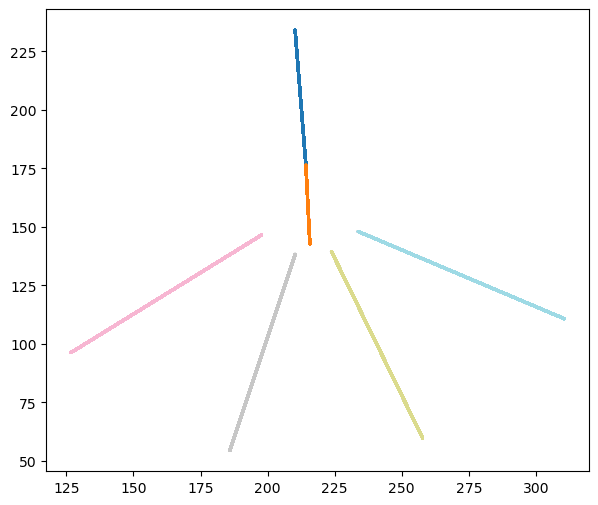

In [29]:
plt.figure(figsize=(7, 6))
plt.scatter(linear_position_df.projected_x_position, linear_position_df.projected_y_position,
            c=linear_position_df.track_segment_id, cmap='tab20', s=1)

We should also plot the linearized position itself to make sure it is okay.

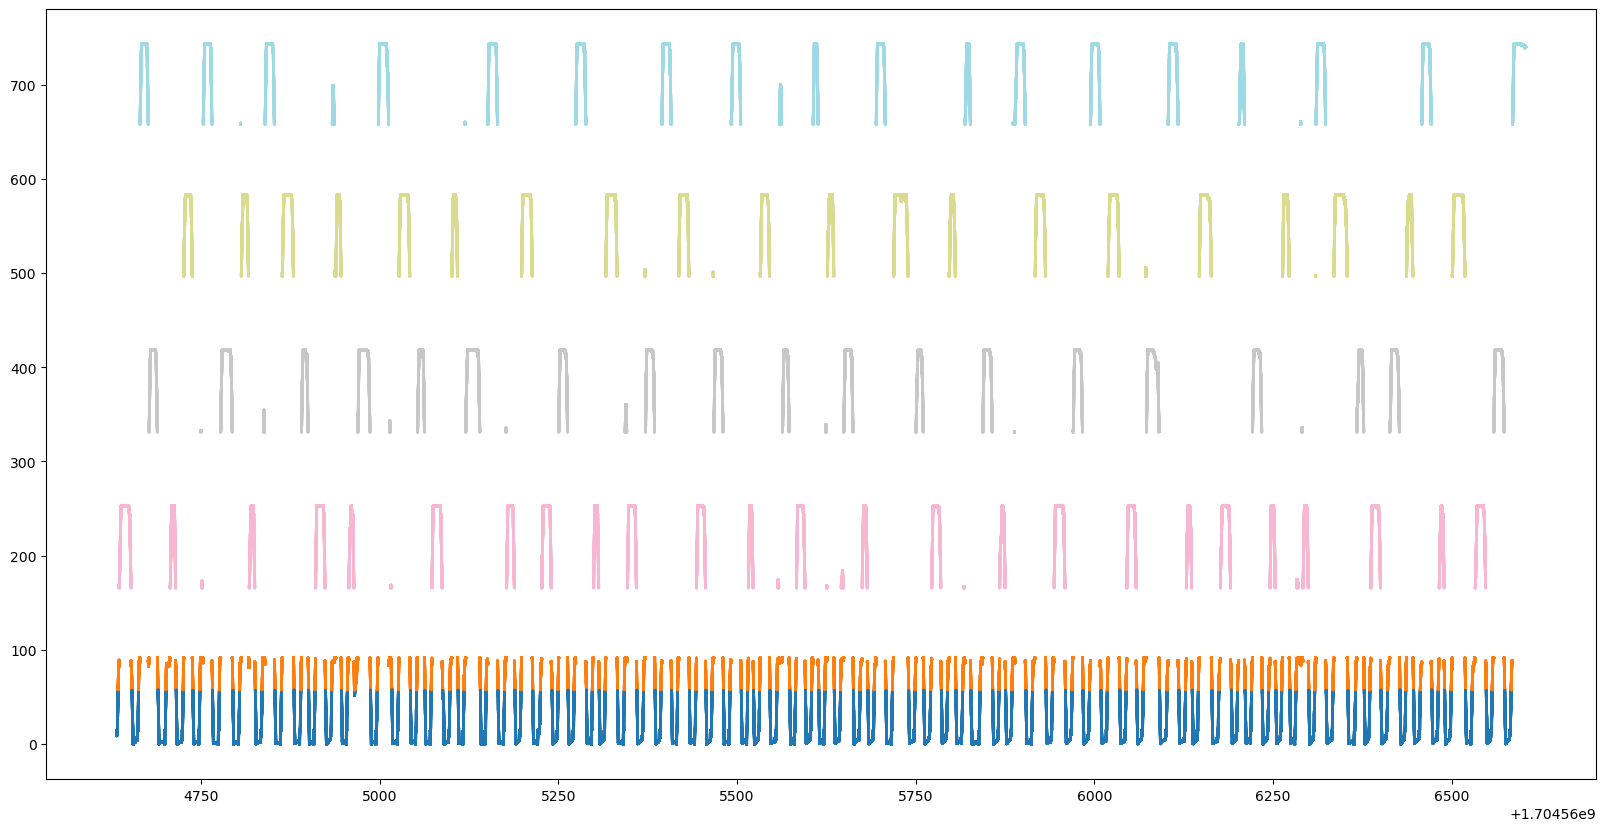

In [30]:
plt.figure(figsize=(20, 10))
plt.scatter(linear_position_df.index, linear_position_df.linear_position, s=1,
            c=linear_position_df.track_segment_id, cmap='tab20')

Okay now that we've looked at the data, we should quickly verify that all our data is the same size.

We also want to make sure we have valid ephys data and valid position data for decoding. Here we only have one valid time interval, but if we had more than one, we should decode on each interval separately.

In [31]:
intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])
marks_=[]
linear_position_df_=[]
position_df_ =[]
for i in range(len(intersect_interval)):
    valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])
    
    linear_position_df_.append(linear_position_df.loc[valid_time_slice])
    position_df_.append(position_df.loc[valid_time_slice])
    marks_.append(marks.sel(time=valid_time_slice))

marks=xr.concat(marks_,dim='time')
position_df = pd.concat(position_df_)
linear_position_df=pd.concat(linear_position_df_)
marks.shape, position_df.shape, linear_position_df.shape

((972285, 4, 43), (972285, 6), (972285, 4))

In [33]:
animal = nwb_copy_file_name[:5]
marks_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_marks.nc')
marks.to_netcdf(marks_path)

position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
linear_position_df.to_csv(position1d_path)

position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
position_df.to_csv(position2d_path)

In [34]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e],
     'marks':marks_path,
     'position_1d':position1d_path,
     'position_2d':position2d_path}
DecodeIngredients().insert1(key,replace=True)

In [19]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
DecodeIngredients() & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"
eliot20221021_.nwb,02_Seq2Session1,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,04_Seq2Session2,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,06_Seq2Session3,=BLOB=,=BLOB=,=BLOB=
eliot20221021_.nwb,08_Seq2Session4,=BLOB=,=BLOB=,=BLOB=


# Run All sessions

In [105]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(nwb_copy_file_name)
print(session_interval)

lewis20240110_.nwb
['02_Rev2Session1', '04_Rev2Session2', '06_Rev2Session3', '08_Rev2Session4', '10_Rev2Session5']


In [20]:
sleep_interval, sleep_position_interval = sleepSessionNames(nwb_copy_file_name)
print(nwb_copy_file_name)
print(sleep_interval)

eliot20221021_.nwb
['01_Seq2Sleep1', '03_Seq2Sleep2', '05_Seq2Sleep3', '07_Seq2Sleep4', '09_Seq2Sleep5']


In [93]:
for e in session_interval:
    decodePrepMasterSession(nwb_copy_file_name,e,populate = True)

0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
done inserting into IntervalList
37
inserting into IntervalList
done inserting 

[15:03:05][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 34, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:03:05 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 34, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1261 [00:00<?, ?it/s]

[15:03:08][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:03:08 Saving sorting results...
[15:03:10][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 37, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:03:10 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 37, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_37_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/1261 [00:00<?, ?it/s]

[15:03:13][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:03:13 Saving sorting results...
[15:03:13][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 39, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:03:13 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 39, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_39_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/1261 [00:00<?, ?it/s]

[15:03:18][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:03:18 Saving sorting results...
[15:03:20][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 43, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_43_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:03:20 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 43, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_43_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/1261 [00:00<?, ?it/s]

[15:03:23][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:03:23 Saving sorting results...
[15:03:25][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 46, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_46_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:03:25 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 46, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_46_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/1261 [00:00<?, ?it/s]

[15:03:28][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:03:28 Saving sorting results...
[15:03:30][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 50, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:03:30 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 50, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_50_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/1261 [00:00<?, ?it/s]

[15:03:33][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:03:33 Saving sorting results...
[15:03:35][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 53, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:03:35 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 53, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_53_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/1261 [00:00<?, ?it/s]

[15:03:39][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:03:39 Saving sorting results...
[15:03:39][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 55, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_55_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:03:39 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 55, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_55_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/1261 [00:00<?, ?it/s]

[15:03:43][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:03:43 Saving sorting results...
[15:03:43][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 61, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:03:43 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 61, 'sort_interval_name': '02_SeqSession1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_02_SeqSession1_61_franklab_tetrode_hippocampus_ampl_1500_p

detect peaks using locally_exclusive:   0%|          | 0/1261 [00:00<?, ?it/s]

[15:03:46][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:03:46 Saving sorting results...
[15:04:32][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:04:32 Found 1 accepted units
[15:04:35][INFO] Spyglass: Writing new NWB file molly20220415_00ZA26H7Y0.nwb
05-Dec-24 15:04:35 Writing new NWB file molly20220415_00ZA26H7Y0.nwb
[15:04:39][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:04:39 Found 1 accepted units
[15:04:40][INFO] Spyglass: Writing new NWB file molly20220415_0FOX8Y4OON.nwb
05-Dec-24 15:04:40 Writing new NWB file molly20220415_0FOX8Y4OON.nwb
[15:04:44][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:04:44 Found 1 accepted units
[15:04:45][INFO] Spyglass: Writing new NWB file molly20220415_KE6WY1Z0YO.nwb
05-Dec-24 15:04:45 Writing new NWB file molly20220415_KE6WY1Z0YO.nwb
[15:04:51][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:04:51 Found 1 accepted units
[15:04:52][INFO] Spyglass: Writing new NWB file molly20220415_JFMZU2Q2BA.nwb
05-Dec-24 15:04:52 

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:05:24][INFO] Spyglass: Writing new NWB file molly20220415_LLUZFJ9UGM.nwb
05-Dec-24 15:05:24 Writing new NWB file molly20220415_LLUZFJ9UGM.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:05:33][INFO] Spyglass: Writing new NWB file molly20220415_H6TMP5ONGN.nwb
05-Dec-24 15:05:33 Writing new NWB file molly20220415_H6TMP5ONGN.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:05:41][INFO] Spyglass: Writing new NWB file molly20220415_BP9PE4AM0T.nwb
05-Dec-24 15:05:41 Writing new NWB file molly20220415_BP9PE4AM0T.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:05:48][INFO] Spyglass: Writing new NWB file molly20220415_XSGMP933SZ.nwb
05-Dec-24 15:05:48 Writing new NWB file molly20220415_XSGMP933SZ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:05:55][INFO] Spyglass: Writing new NWB file molly20220415_I6EE0YYPQ8.nwb
05-Dec-24 15:05:55 Writing new NWB file molly20220415_I6EE0YYPQ8.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:06:02][INFO] Spyglass: Writing new NWB file molly20220415_QOKK3LV9WQ.nwb
05-Dec-24 15:06:02 Writing new NWB file molly20220415_QOKK3LV9WQ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:06:09][INFO] Spyglass: Writing new NWB file molly20220415_JTLZEN5I2L.nwb
05-Dec-24 15:06:09 Writing new NWB file molly20220415_JTLZEN5I2L.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:06:14][INFO] Spyglass: Writing new NWB file molly20220415_50U2O70DF4.nwb
05-Dec-24 15:06:14 Writing new NWB file molly20220415_50U2O70DF4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:06:23][INFO] Spyglass: Writing new NWB file molly20220415_ZMZGSI266A.nwb
05-Dec-24 15:06:23 Writing new NWB file molly20220415_ZMZGSI266A.nwb
[15:06:28][INFO] Spyglass: Writing new NWB file molly20220415_HNU8TEMOJM.nwb
05-Dec-24 15:06:28 Writing new NWB file molly20220415_HNU8TEMOJM.nwb
[15:06:37][INFO] Spyglass: Writing new NWB file molly20220415_W8SIHQ2K9Y.nwb
05-Dec-24 15:06:37 Writing new NWB file molly20220415_W8SIHQ2K9Y.nwb
[15:06:47][INFO] Spyglass: Writing new NWB file molly20220415_C23S3IRCG5.nwb
05-Dec-24 15:06:47 Writing new NWB file molly20220415_C23S3IRCG5.nwb
[15:06:57][INFO] Spyglass: Writing new NWB file molly20220415_6B5G8O1F6O.nwb
05-Dec-24 15:06:57 Writing new NWB file molly20220415_6B5G8O1F6O.nwb
[15:07:06][INFO] Spyglass: Writing new NWB file molly20220415_UW7X4EH0AH.nwb
05-Dec-24 15:07:06 Writing new NWB file molly20220415_UW7X4EH0AH.nwb
[15:07:16][INFO] Spyglass: Writing new NWB file molly20220415_XBWIBTRXN0.nwb
05-Dec-24 15:07:16 Writing new NWB file molly20

final shape of marks and linear position df is:
(594331, 4, 25)
(594331, 4)
0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
don

[15:08:26][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 34, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:08:26 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 34, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2119 [00:00<?, ?it/s]

[15:08:30][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:08:30 Saving sorting results...
[15:08:34][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 37, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:08:34 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 37, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_37_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2119 [00:00<?, ?it/s]

[15:08:38][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:08:38 Saving sorting results...
[15:08:42][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 39, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:08:42 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 39, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_39_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2119 [00:00<?, ?it/s]

[15:08:47][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:08:47 Saving sorting results...
[15:08:50][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 43, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_43_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:08:50 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 43, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_43_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2119 [00:00<?, ?it/s]

[15:08:55][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:08:55 Saving sorting results...
[15:08:59][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 46, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_46_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:08:59 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 46, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_46_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2119 [00:00<?, ?it/s]

[15:09:04][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:09:04 Saving sorting results...
[15:09:07][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 50, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:09:07 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 50, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_50_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2119 [00:00<?, ?it/s]

[15:09:12][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:09:12 Saving sorting results...
[15:09:15][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 53, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:09:15 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 53, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_53_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2119 [00:00<?, ?it/s]

[15:09:22][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:09:22 Saving sorting results...
[15:09:25][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 55, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_55_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:09:25 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 55, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_55_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2119 [00:00<?, ?it/s]

[15:09:32][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:09:32 Saving sorting results...
[15:09:32][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 61, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:09:32 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 61, 'sort_interval_name': '04_Seq2Session1', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_04_Seq2Session1_61_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2119 [00:00<?, ?it/s]

[15:09:37][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:09:37 Saving sorting results...
[15:10:22][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:10:22 Found 1 accepted units
[15:10:24][INFO] Spyglass: Writing new NWB file molly20220415_FHM9PCETE4.nwb
05-Dec-24 15:10:24 Writing new NWB file molly20220415_FHM9PCETE4.nwb
[15:10:27][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:10:27 Found 1 accepted units
[15:10:28][INFO] Spyglass: Writing new NWB file molly20220415_YOL4KLG46I.nwb
05-Dec-24 15:10:28 Writing new NWB file molly20220415_YOL4KLG46I.nwb
[15:10:32][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:10:32 Found 1 accepted units
[15:10:34][INFO] Spyglass: Writing new NWB file molly20220415_PXOKU3WVCK.nwb
05-Dec-24 15:10:34 Writing new NWB file molly20220415_PXOKU3WVCK.nwb
[15:10:40][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:10:40 Found 1 accepted units
[15:10:41][INFO] Spyglass: Writing new NWB file molly20220415_FWH3NSQTUL.nwb
05-Dec-24 15:10:41 

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:11:16][INFO] Spyglass: Writing new NWB file molly20220415_WKY440ACE4.nwb
05-Dec-24 15:11:16 Writing new NWB file molly20220415_WKY440ACE4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:11:27][INFO] Spyglass: Writing new NWB file molly20220415_FW2Z3Z8TLO.nwb
05-Dec-24 15:11:27 Writing new NWB file molly20220415_FW2Z3Z8TLO.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:11:37][INFO] Spyglass: Writing new NWB file molly20220415_2ONV4D7V20.nwb
05-Dec-24 15:11:37 Writing new NWB file molly20220415_2ONV4D7V20.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:11:45][INFO] Spyglass: Writing new NWB file molly20220415_TDC1VCCOPQ.nwb
05-Dec-24 15:11:45 Writing new NWB file molly20220415_TDC1VCCOPQ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:11:52][INFO] Spyglass: Writing new NWB file molly20220415_70NZC0CN00.nwb
05-Dec-24 15:11:52 Writing new NWB file molly20220415_70NZC0CN00.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:12:01][INFO] Spyglass: Writing new NWB file molly20220415_K7HVN15D5F.nwb
05-Dec-24 15:12:01 Writing new NWB file molly20220415_K7HVN15D5F.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:12:09][INFO] Spyglass: Writing new NWB file molly20220415_601MGCC23P.nwb
05-Dec-24 15:12:09 Writing new NWB file molly20220415_601MGCC23P.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:12:16][INFO] Spyglass: Writing new NWB file molly20220415_BV760IVDQA.nwb
05-Dec-24 15:12:16 Writing new NWB file molly20220415_BV760IVDQA.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:12:26][INFO] Spyglass: Writing new NWB file molly20220415_K04WPK0JGT.nwb
05-Dec-24 15:12:26 Writing new NWB file molly20220415_K04WPK0JGT.nwb
[15:12:30][INFO] Spyglass: Writing new NWB file molly20220415_CZER5HQ93T.nwb
05-Dec-24 15:12:30 Writing new NWB file molly20220415_CZER5HQ93T.nwb
[15:12:44][INFO] Spyglass: Writing new NWB file molly20220415_HZW9PU5GVT.nwb
05-Dec-24 15:12:44 Writing new NWB file molly20220415_HZW9PU5GVT.nwb
[15:12:57][INFO] Spyglass: Writing new NWB file molly20220415_KKBAET5HCW.nwb
05-Dec-24 15:12:57 Writing new NWB file molly20220415_KKBAET5HCW.nwb
[15:13:10][INFO] Spyglass: Writing new NWB file molly20220415_UZR2X3QQHI.nwb
05-Dec-24 15:13:10 Writing new NWB file molly20220415_UZR2X3QQHI.nwb
[15:13:23][INFO] Spyglass: Writing new NWB file molly20220415_2T7CE8NAN6.nwb
05-Dec-24 15:13:23 Writing new NWB file molly20220415_2T7CE8NAN6.nwb
[15:13:37][INFO] Spyglass: Writing new NWB file molly20220415_JLTD46EU84.nwb
05-Dec-24 15:13:37 Writing new NWB file molly20

final shape of marks and linear position df is:
(987648, 4, 25)
(987648, 4)
0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
don

[15:15:15][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 34, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:15:15 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 34, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/1994 [00:00<?, ?it/s]

[15:15:23][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:15:23 Saving sorting results...
[15:15:26][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 37, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:15:26 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 37, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_37_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/1994 [00:00<?, ?it/s]

[15:15:29][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:15:29 Saving sorting results...
[15:15:33][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 39, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:15:33 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 39, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_39_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/1994 [00:00<?, ?it/s]

[15:15:36][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:15:36 Saving sorting results...
[15:15:37][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 43, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_43_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:15:37 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 43, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_43_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/1994 [00:00<?, ?it/s]

[15:15:42][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:15:42 Saving sorting results...
[15:15:46][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 46, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_46_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:15:46 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 46, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_46_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/1994 [00:00<?, ?it/s]

[15:15:49][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:15:49 Saving sorting results...
[15:15:53][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 50, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:15:53 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 50, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_50_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/1994 [00:00<?, ?it/s]

[15:15:56][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:15:56 Saving sorting results...
[15:16:00][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 53, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:16:00 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 53, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_53_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/1994 [00:00<?, ?it/s]

[15:16:03][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:16:03 Saving sorting results...
[15:16:04][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 55, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_55_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:16:04 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 55, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_55_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/1994 [00:00<?, ?it/s]

[15:16:09][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:16:09 Saving sorting results...
[15:16:12][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 61, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:16:12 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 61, 'sort_interval_name': '06_Seq2Session2', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_06_Seq2Session2_61_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/1994 [00:00<?, ?it/s]

[15:16:15][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:16:15 Saving sorting results...
[15:17:08][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:17:08 Found 1 accepted units
[15:17:14][INFO] Spyglass: Writing new NWB file molly20220415_IMPG6D29XC.nwb
05-Dec-24 15:17:14 Writing new NWB file molly20220415_IMPG6D29XC.nwb
[15:17:18][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:17:18 Found 1 accepted units
[15:17:20][INFO] Spyglass: Writing new NWB file molly20220415_95108M0TLM.nwb
05-Dec-24 15:17:20 Writing new NWB file molly20220415_95108M0TLM.nwb
[15:17:23][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:17:23 Found 1 accepted units
[15:17:25][INFO] Spyglass: Writing new NWB file molly20220415_SNWS09978U.nwb
05-Dec-24 15:17:25 Writing new NWB file molly20220415_SNWS09978U.nwb
[15:17:29][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:17:29 Found 1 accepted units
[15:17:31][INFO] Spyglass: Writing new NWB file molly20220415_FBNJBOW0P1.nwb
05-Dec-24 15:17:31 

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:18:05][INFO] Spyglass: Writing new NWB file molly20220415_FHEA2M26GU.nwb
05-Dec-24 15:18:05 Writing new NWB file molly20220415_FHEA2M26GU.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:18:13][INFO] Spyglass: Writing new NWB file molly20220415_5N7W7R6ASB.nwb
05-Dec-24 15:18:13 Writing new NWB file molly20220415_5N7W7R6ASB.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:18:21][INFO] Spyglass: Writing new NWB file molly20220415_HXQZ5QIGJR.nwb
05-Dec-24 15:18:21 Writing new NWB file molly20220415_HXQZ5QIGJR.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:18:30][INFO] Spyglass: Writing new NWB file molly20220415_AD9BHGZ0GO.nwb
05-Dec-24 15:18:30 Writing new NWB file molly20220415_AD9BHGZ0GO.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:18:36][INFO] Spyglass: Writing new NWB file molly20220415_K3295N0TWS.nwb
05-Dec-24 15:18:36 Writing new NWB file molly20220415_K3295N0TWS.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:18:44][INFO] Spyglass: Writing new NWB file molly20220415_TDJ43AGELO.nwb
05-Dec-24 15:18:44 Writing new NWB file molly20220415_TDJ43AGELO.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:18:51][INFO] Spyglass: Writing new NWB file molly20220415_R31Q6FO5RQ.nwb
05-Dec-24 15:18:51 Writing new NWB file molly20220415_R31Q6FO5RQ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:18:58][INFO] Spyglass: Writing new NWB file molly20220415_HABMDZJPCJ.nwb
05-Dec-24 15:18:58 Writing new NWB file molly20220415_HABMDZJPCJ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:19:04][INFO] Spyglass: Writing new NWB file molly20220415_QQXSKFVW3J.nwb
05-Dec-24 15:19:04 Writing new NWB file molly20220415_QQXSKFVW3J.nwb
[15:19:09][INFO] Spyglass: Writing new NWB file molly20220415_1T1XL3ICXG.nwb
05-Dec-24 15:19:09 Writing new NWB file molly20220415_1T1XL3ICXG.nwb
[15:19:22][INFO] Spyglass: Writing new NWB file molly20220415_R0T57JNDB9.nwb
05-Dec-24 15:19:22 Writing new NWB file molly20220415_R0T57JNDB9.nwb
[15:19:35][INFO] Spyglass: Writing new NWB file molly20220415_Q13GTDERM1.nwb
05-Dec-24 15:19:35 Writing new NWB file molly20220415_Q13GTDERM1.nwb
[15:19:47][INFO] Spyglass: Writing new NWB file molly20220415_2TI8FLXF0V.nwb
05-Dec-24 15:19:47 Writing new NWB file molly20220415_2TI8FLXF0V.nwb
[15:19:59][INFO] Spyglass: Writing new NWB file molly20220415_MD0RWOFBC5.nwb
05-Dec-24 15:19:59 Writing new NWB file molly20220415_MD0RWOFBC5.nwb
[15:20:11][INFO] Spyglass: Writing new NWB file molly20220415_EPH6HIREX2.nwb
05-Dec-24 15:20:11 Writing new NWB file molly20

final shape of marks and linear position df is:
(879983, 4, 25)
(879983, 4)
0
inserting into IntervalList
done inserting into IntervalList
2
inserting into IntervalList
done inserting into IntervalList
3
inserting into IntervalList
done inserting into IntervalList
6
inserting into IntervalList
done inserting into IntervalList
7
inserting into IntervalList
done inserting into IntervalList
9
inserting into IntervalList
done inserting into IntervalList
12
inserting into IntervalList
done inserting into IntervalList
15
inserting into IntervalList
done inserting into IntervalList
17
inserting into IntervalList
done inserting into IntervalList
18
inserting into IntervalList
done inserting into IntervalList
24
inserting into IntervalList
done inserting into IntervalList
25
inserting into IntervalList
done inserting into IntervalList
27
inserting into IntervalList
done inserting into IntervalList
28
inserting into IntervalList
done inserting into IntervalList
34
inserting into IntervalList
don

[15:21:46][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 34, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:21:46 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 34, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_34_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...


detect peaks using locally_exclusive:   0%|          | 0/2093 [00:00<?, ?it/s]

[15:21:50][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:21:50 Saving sorting results...
[15:21:54][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 37, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_37_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:21:54 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 37, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_37_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2093 [00:00<?, ?it/s]

[15:21:58][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:21:58 Saving sorting results...
[15:22:01][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 39, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_39_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:22:01 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 39, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_39_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2093 [00:00<?, ?it/s]

[15:22:06][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:22:06 Saving sorting results...
[15:22:07][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 43, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_43_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:22:07 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 43, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_43_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2093 [00:00<?, ?it/s]

[15:22:13][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:22:13 Saving sorting results...
[15:22:16][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 46, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_46_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:22:16 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 46, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_46_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2093 [00:00<?, ?it/s]

[15:22:20][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:22:20 Saving sorting results...
[15:22:24][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 50, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_50_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:22:24 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 50, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_50_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2093 [00:00<?, ?it/s]

[15:22:28][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:22:28 Saving sorting results...
[15:22:31][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 53, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_53_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:22:31 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 53, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_53_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2093 [00:00<?, ?it/s]

[15:22:35][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:22:35 Saving sorting results...
[15:22:35][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 55, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_55_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:22:35 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 55, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_55_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2093 [00:00<?, ?it/s]

[15:22:39][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:22:39 Saving sorting results...
[15:22:42][INFO] Spyglass: Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 61, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_61_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only'}...
05-Dec-24 15:22:42 Running spike sorting on {'nwb_file_name': 'molly20220415_.nwb', 'sort_group_id': 61, 'sort_interval_name': '08_Seq2Session3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220415_.nwb_08_Seq2Session3_61_franklab_tetrode_hippocampus_ampl_15

detect peaks using locally_exclusive:   0%|          | 0/2093 [00:00<?, ?it/s]

[15:22:45][INFO] Spyglass: Saving sorting results...
05-Dec-24 15:22:45 Saving sorting results...
[15:23:29][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:23:29 Found 1 accepted units
[15:23:30][INFO] Spyglass: Writing new NWB file molly20220415_3JGN2DFFYQ.nwb
05-Dec-24 15:23:30 Writing new NWB file molly20220415_3JGN2DFFYQ.nwb
[15:23:34][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:23:34 Found 1 accepted units
[15:23:35][INFO] Spyglass: Writing new NWB file molly20220415_3CY3TL0VI4.nwb
05-Dec-24 15:23:35 Writing new NWB file molly20220415_3CY3TL0VI4.nwb
[15:23:38][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:23:38 Found 1 accepted units
[15:23:40][INFO] Spyglass: Writing new NWB file molly20220415_2OTF468OWZ.nwb
05-Dec-24 15:23:40 Writing new NWB file molly20220415_2OTF468OWZ.nwb
[15:23:43][INFO] Spyglass: Found 1 accepted units
05-Dec-24 15:23:43 Found 1 accepted units
[15:23:44][INFO] Spyglass: Writing new NWB file molly20220415_9IJ99F0SL2.nwb
05-Dec-24 15:23:44 

extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:24:17][INFO] Spyglass: Writing new NWB file molly20220415_I67VHPP1MG.nwb
05-Dec-24 15:24:17 Writing new NWB file molly20220415_I67VHPP1MG.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:24:25][INFO] Spyglass: Writing new NWB file molly20220415_XKA87HBZDR.nwb
05-Dec-24 15:24:25 Writing new NWB file molly20220415_XKA87HBZDR.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:24:33][INFO] Spyglass: Writing new NWB file molly20220415_WLC2745R3L.nwb
05-Dec-24 15:24:33 Writing new NWB file molly20220415_WLC2745R3L.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:24:40][INFO] Spyglass: Writing new NWB file molly20220415_8L35YVS8JY.nwb
05-Dec-24 15:24:40 Writing new NWB file molly20220415_8L35YVS8JY.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:24:48][INFO] Spyglass: Writing new NWB file molly20220415_ER21POMX1Y.nwb
05-Dec-24 15:24:48 Writing new NWB file molly20220415_ER21POMX1Y.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:24:55][INFO] Spyglass: Writing new NWB file molly20220415_XJT0GI203Y.nwb
05-Dec-24 15:24:55 Writing new NWB file molly20220415_XJT0GI203Y.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:25:03][INFO] Spyglass: Writing new NWB file molly20220415_1QVLIE8ZKN.nwb
05-Dec-24 15:25:03 Writing new NWB file molly20220415_1QVLIE8ZKN.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:25:09][INFO] Spyglass: Writing new NWB file molly20220415_UNX9H6N7W9.nwb
05-Dec-24 15:25:09 Writing new NWB file molly20220415_UNX9H6N7W9.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

[15:25:16][INFO] Spyglass: Writing new NWB file molly20220415_N3GEOK1F9U.nwb
05-Dec-24 15:25:16 Writing new NWB file molly20220415_N3GEOK1F9U.nwb
[15:25:20][INFO] Spyglass: Writing new NWB file molly20220415_XZ6EFZMR7N.nwb
05-Dec-24 15:25:20 Writing new NWB file molly20220415_XZ6EFZMR7N.nwb
[15:25:33][INFO] Spyglass: Writing new NWB file molly20220415_YOFTNM3VVF.nwb
05-Dec-24 15:25:33 Writing new NWB file molly20220415_YOFTNM3VVF.nwb
[15:25:46][INFO] Spyglass: Writing new NWB file molly20220415_XK6KVTA5HM.nwb
05-Dec-24 15:25:46 Writing new NWB file molly20220415_XK6KVTA5HM.nwb
[15:26:00][INFO] Spyglass: Writing new NWB file molly20220415_9XADBU1MAC.nwb
05-Dec-24 15:26:00 Writing new NWB file molly20220415_9XADBU1MAC.nwb
[15:26:13][INFO] Spyglass: Writing new NWB file molly20220415_5VNLOMRO95.nwb
05-Dec-24 15:26:13 Writing new NWB file molly20220415_5VNLOMRO95.nwb
[15:26:26][INFO] Spyglass: Writing new NWB file molly20220415_EYHPHVCN3G.nwb
05-Dec-24 15:26:26 Writing new NWB file molly20

final shape of marks and linear position df is:
(804104, 4, 25)
(804104, 4)


In [ ]:
ArtifactDetectionSelection

In [22]:
for e in sleep_interval:
    thresholder_sort(nwb_copy_file_name,e,True)

0


IntegrityError: Cannot add or update a child row: a foreign key constraint fails (`spikesorting_artifact`.`artifact_detection_selection`, CONSTRAINT `artifact_detection_selection_ibfk_1` FOREIGN KEY (`nwb_file_name`, `sort_group_id`, `sort_interval_name`, `preproc_params_na)

In [23]:
%debug

> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/datajoint/connection.py(296)_execute_query()
    294                 cursor.execute(query, args)
    295         except client.err.Error as err:
--> 296             raise translate_query_error(err, query)
    297 
    298     def query(



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/datajoint/connection.py(340)query()
    338         cursor = self._conn.cursor(cursor=cursor_class)
    339         try:
--> 340             self._execute_query(cursor, query, args, suppress_warnings)
    341         except errors.LostConnectionError:
    342             if not reconnect:



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/datajoint/table.py(440)insert()
    438                     ),
    439                 )
--> 440                 self.connection.query(
    441                     query,
    442                     args=list(



ipdb>  u


> /home/shijiegu/anaconda3/envs/spyglass/lib/python3.9/site-packages/datajoint/table.py(337)insert1()
    335             as one row.
    336         """
--> 337         self.insert((row,), **kwargs)
    338 
    339     def insert(



ipdb>  u


> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/decodeHelpers.py(249)thresholder_sort()
    247 
    248         if populate:
--> 249             ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)
    250 
    251         artifact_key['artifact_times']=artifact_time_list



ipdb>  artifact_key


{'nwb_file_name': 'eliot20221021_.nwb', 'sort_interval_name': '01_Seq2Sleep1', 'sort_group_id': 0, 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'artifact_params_name': 'ampl_1500_prop_075_1ms'}


ipdb>  exit


In [24]:
SpikeSortingRecording & {'nwb_file_name': 'eliot20221021_.nwb', 'sort_interval_name': '01_Seq2Sleep1'}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list


In [10]:
from spyglass.shijiegu.Analysis_SGU import DecodeIngredients
key={'nwb_file_name':nwb_copy_file_name}
DecodeIngredients() & key

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,marks valid marks within that interval,"position_1d valid position within that interval (1D), inluding all rat-on-track time","position_2d valid position within that interval (2D), inluding all rat-on-track time"


In [98]:
(SpikeSortingSelection & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,import_path optional path to previous curated sorting output
molly20220415_.nwb,0,01_SeqSleep1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_01_SeqSleep1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220415_.nwb,0,02_SeqSession1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_02_SeqSession1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220415_.nwb,0,02_SeqSession1,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,molly20220415_.nwb_02_SeqSession1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220415_.nwb,0,03_SeqSleep2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_03_SeqSleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220415_.nwb,0,04_Seq2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_04_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220415_.nwb,0,04_Seq2Session1,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,molly20220415_.nwb_04_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220415_.nwb,0,05_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_05_Seq2Sleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220415_.nwb,0,06_Seq2Session2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_06_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220415_.nwb,0,06_Seq2Session2,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,molly20220415_.nwb_06_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,
molly20220415_.nwb,0,07_Seq2Sleep3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_07_Seq2Sleep3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,


In [97]:
(SpikeSorting & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
molly20220415_.nwb,0,01_SeqSleep1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_01_SeqSleep1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_01_SeqSleep1_0_franklab_tetrode_hippocampus_a1942e35_spikesorting,1732918641
molly20220415_.nwb,0,02_SeqSession1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_02_SeqSession1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_02_SeqSession1_0_franklab_tetrode_hippocampus_0b168993_spikesorting,1732908828
molly20220415_.nwb,0,02_SeqSession1,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,molly20220415_.nwb_02_SeqSession1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_02_SeqSession1_0_franklab_tetrode_hippocampus_8fe7bc6d_spikesorting,1733377879
molly20220415_.nwb,0,03_SeqSleep2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_03_SeqSleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_03_SeqSleep2_0_franklab_tetrode_hippocampus_7f5b1cb9_spikesorting,1732918792
molly20220415_.nwb,0,04_Seq2Session1,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_04_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_04_Seq2Session1_0_franklab_tetrode_hippocampus_dfacc142_spikesorting,1732915509
molly20220415_.nwb,0,04_Seq2Session1,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,molly20220415_.nwb_04_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_04_Seq2Session1_0_franklab_tetrode_hippocampus_d637aa72_spikesorting,1733379381
molly20220415_.nwb,0,05_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_05_Seq2Sleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_05_Seq2Sleep2_0_franklab_tetrode_hippocampus_7e845968_spikesorting,1732918966
molly20220415_.nwb,0,06_Seq2Session2,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_06_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_06_Seq2Session2_0_franklab_tetrode_hippocampus_2b632e33_spikesorting,1732916609
molly20220415_.nwb,0,06_Seq2Session2,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,molly20220415_.nwb_06_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_06_Seq2Session2_0_franklab_tetrode_hippocampus_b02814cf_spikesorting,1733381719
molly20220415_.nwb,0,07_Seq2Sleep3,franklab_tetrode_hippocampus,SequenceTask,clusterless_thresholder,default,molly20220415_.nwb_07_Seq2Sleep3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times_track_time_only,/stelmo/nwb/sorting/molly20220415_.nwb_07_Seq2Sleep3_0_franklab_tetrode_hippocampus_aadce58c_spikesorting,1733442805


# END HERE

In [2]:
## try loading
nwb_copy_file_name = 'lewis20240121_.nwb'

In [44]:
e=0

In [45]:
entry = DecodeIngredients & {'nwb_file_name':nwb_copy_file_name,
     'interval_list_name':session_interval[e]}
marks = xr.open_dataset(entry.fetch1('marks'))
position_1d = pd.read_csv(entry.fetch1('position_1d'))
position_2d = pd.read_csv(entry.fetch1('position_2d'))

In [46]:
marks

<xarray.Dataset>
Dimensions:                        (time: 958279, marks: 4, electrodes: 15)
Coordinates:
  * time                           (time) float64 1.667e+09 ... 1.667e+09
  * electrodes                     (electrodes) int32 0 2 4 5 13 ... 28 29 30 31
  * marks                          (marks) object 'amplitude_0000' ... 'ampli...
Data variables:
    __xarray_dataarray_variable__  (time, marks, electrodes) float32 ...

In [47]:
for e in range(len(session_interval)):
    """
    Position: UnitMarksIndicator
    """
    linear_position_df = (IntervalLinearizedPosition() &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
        ).fetch1_dataframe()
    position_df = (IntervalPositionInfo &
        {'nwb_file_name': nwb_copy_file_name,
        'interval_list_name': position_interval[e],
        'position_info_param_name': 'default_decoding'}
                    ).fetch1_dataframe()

    # Remove Data before 1st trial and after last trial
    StateScript = pd.DataFrame(
        (TrialChoice & {'nwb_file_name':nwb_copy_file_name,
                        'epoch_name':session_interval[e]}).fetch1('choice_reward'))

    trial_1_t = StateScript.loc[1].timestamp_O
    trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
    linear_position_df = removeDataBeforeTrial1(linear_position_df,trial_1_t,trial_last_t)
    position_df = removeDataBeforeTrial1(position_df,trial_1_t,trial_last_t)

    """
    Intervals
    """
    intersect_interval = intersectValidIntervals(nwb_copy_file_name,
                                                session_interval[e],position_interval[e])

    linear_position_df_=[]
    position_df_ =[]
    for i in range(len(intersect_interval)):
        valid_time_slice = slice(intersect_interval[i][0], intersect_interval[i][1])

        linear_position_df_.append(linear_position_df.loc[valid_time_slice])
        position_df_.append(position_df.loc[valid_time_slice])


    linear_position_df=pd.concat(linear_position_df_)
    position_df=pd.concat(position_df_)
    print('final shape of marks and linear position df is:')

    print(linear_position_df.shape)

    """save result"""
    animal = nwb_copy_file_name[:5]


    position1d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_1dposition.csv')
    linear_position_df.to_csv(position1d_path)

    position2d_path=os.path.join(f'/cumulus/shijie/recording_pilot/{animal}/decoding',
                             nwb_copy_file_name+'_'+session_interval[e]+'_2dposition.csv')
    position_df.to_csv(position2d_path)

[09:47:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:09 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(958279, 4)


[09:47:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:22 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(885994, 4)


[09:47:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:34 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(843218, 4)


[09:47:46][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
16-Jun-24 09:47:46 Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


final shape of marks and linear position df is:
(783223, 4)
